In [1]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import glob


In [32]:
fits_list =glob.glob("/home/kevin/WORK/coding/sdsswork/sdss_spectra/sky_flux/sdss_fits_files/*.fits")


In [33]:
#Extra the fits tables from all the globbed fits
specdata_list=[]
for i in fits_list:
    with fits.open(i) as fit_file:
        specdata=fit_file[1].data
        header=fit_file[0].header
        specdata_list.append(specdata)


#Get the shapes of each spectra then find the smallest shape along 0 axis
spec_shape_list=[]
for i in specdata_list:
    spec_shape_list.append(i.shape)
spec_shape_list=np.array(spec_shape_list)
smallest_spec=np.min(spec_shape_list)

#Filtering routine

# Finding a target lenght for filtering
target_length = sum((3.582 <= lam <= 3.957) for lam in specdata_list[0].loglam)

spectra_filtered_list = []
for i in specdata_list:
    spec = i
    # Apply boolean mask along lambda axis from 3.582 to 3.957
    mask = (spec.loglam >= 3.582) & (spec.loglam <= 3.957)
    filtered_data = spec[mask]
    
    # Adjust the length to match target_length
    if len(filtered_data) < target_length:
        # If shorter, pad with NaNs or another value of choice and relpace missing vals with mean of the spectrum
        filtered_data = np.pad(filtered_data, (0, target_length - len(filtered_data)), constant_values=np.mean(filtered_data['sky'])) 
    elif len(filtered_data) > target_length:
        # If longer, truncate
        filtered_data = filtered_data[:target_length]
        
    spectra_filtered_list.append(filtered_data)

# Convert to numpy array now that all arrays are the same length
spectra_filtered_list = np.array(spectra_filtered_list)
spectra_filtered_list.shape


(152, 3751)

In [39]:
mean_sky=np.mean(spectra_filtered_list['sky'], axis=0)

In [50]:
sky_res=[]

for sky in spectra_filtered_list['sky']:
    residual=sky-mean_sky
    sky_res.append(residual)
sky_res=np.array(sky_res)

In [75]:
rms_res=np.sqrt( np.mean(sky_res**2, axis=0))

In [61]:
noise=np.mean(spectra_filtered_list['ivar'], axis=0)

In [63]:
weighted_rms=rms_res*noise

In [88]:
import numpy as np

# Assuming sky_res contains the residuals (sky - mean_sky), and ivar is your inverse variance array

# Step 1: Compute the weighted squared residuals (multiply by ivar)
weighted_squared_residuals = sky_res ** 2 * spectra_filtered_list['ivar'] #[:, np.newaxis]  # Broadcasting for 2D ivar

# Step 2: Compute the weighted RMS by averaging the weighted squared residuals and taking the square root
weighted_rms = np.sqrt(np.mean(weighted_squared_residuals, axis=0) / np.mean(spectra_filtered_list['ivar'], axis=0))

print(weighted_rms)



[ 2.0591216  2.051519   2.0627892 ... 28.741274   7.7144036  3.8862178]


In [86]:

spectra_filtered_list['ivar'].shape

(152, 3751)

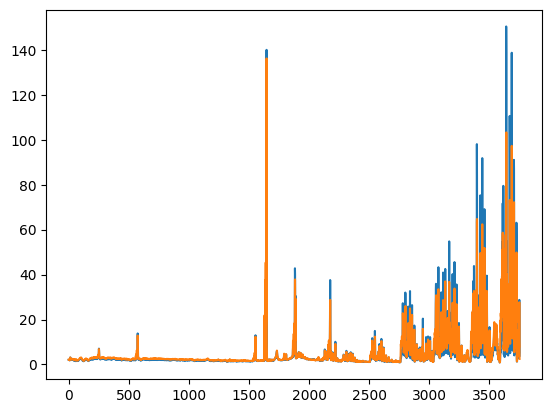

In [90]:
plt.plot(weighted_rms)
plt.plot(rms_res)

In [93]:
# Find the minimum and maximum values of rms_res
rms_min = np.min(rms_res)
rms_max = np.max(rms_res)

# Scale rms_res to the range [1, 10]
scaled_rms_res = ((rms_res - rms_min) / (rms_max - rms_min)) * 4 + 1

print(scaled_rms_res)


[1.0383929 1.0396558 1.0407181 ... 1.7919973 1.2795017 1.0470157]


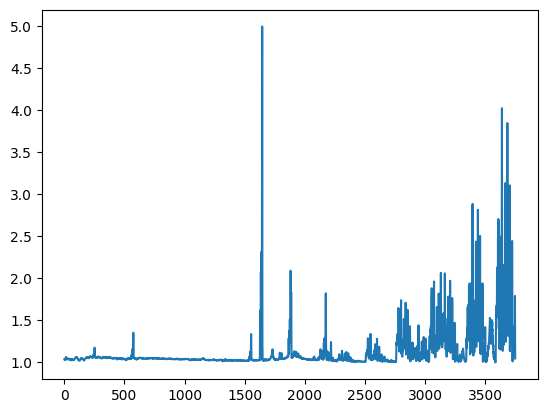

In [94]:
plt.plot(scaled_rms_res)

In [95]:
import numpy as np

# Assuming sky_res contains the residuals (sky - mean_sky), and ivar is your inverse variance array

# Step 1: Compute the weighted squared residuals (multiply by ivar)
weighted_squared_residuals = scaled_rms_res ** 2 * spectra_filtered_list['ivar'] #[:, np.newaxis]  # Broadcasting for 2D ivar

# Step 2: Compute the weighted RMS by averaging the weighted squared residuals and taking the square root
weighted_rms = np.sqrt(np.mean(weighted_squared_residuals, axis=0) / np.mean(spectra_filtered_list['ivar'], axis=0))

print(weighted_rms)



[1.0383929 1.0396556 1.0407181 ... 1.7919972 1.2795016 1.0470158]


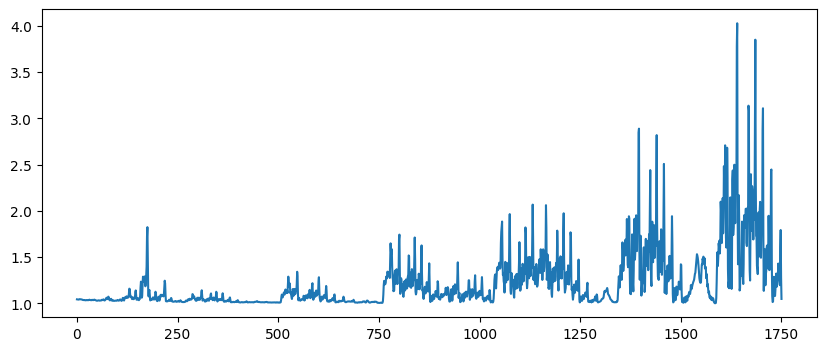

In [98]:
plt.figure(figsize=(10,4))
plt.plot(weighted_rms[2000:])